In [1]:
!pip install tensorflow
!pip install langdetect


[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


--------------------------
# Modèle MLP - Score (étoiles)
- Lucie MASSELIN
--------------------------

## 1. Chargement et échantillonnage

In [1]:
import os

FILE_PATH = r'C:\Users\lucie\OneDrive\Documents\SEMESTRE_6\S6C01-test\data\yelp_academic_reviews4students.jsonl'

if os.path.exists(FILE_PATH):
    print(f"Fichier trouvé. Taille : {round(os.path.getsize(FILE_PATH)/1024/1024, 2)} Mo")
else:
    print("ERREUR : Le fichier n'existe pas au chemin indiqué.")
    
# compter les lignes (1 ligne = 1 avis JSON)
with open(FILE_PATH, "r", encoding="utf-8") as f:
    n_lines = sum(1 for _ in f)

print("Nombre de lignes (avis) :", n_lines)

Fichier trouvé. Taille : 719.56 Mo
Nombre de lignes (avis) : 1000000


A cause de ma RAM j'ai essayer de trouver une solution pour charger que 20 000 lignes du fichier, j'ai donc charger les deux premiers morceaux de 10 000 lignes chacun

In [ ]:
import pandas as pd

chunk_iter = pd.read_json(FILE_PATH, lines=True, chunksize=10000)

# On récupère les deux premiers morceaux pour atteindre tes 20 000 lignes
chunks = []
for i, chunk in enumerate(chunk_iter):
    chunks.append(chunk)
    if i == 1: 
        break

df_sample = pd.concat(chunks)
print(f"Nombre de lignes chargées : {len(df_sample)}")

Nombre de lignes chargées : 20000


## 2. Pré traitement

In [3]:
df = df_sample[["review_id", "business_id", "stars", "text"]].copy()
df = df.dropna(subset=["text", "stars"]).reset_index(drop=True) # Supprimer les lignes ou les text et les étoiles sont manquantes 

print("Shape:", df.shape)
df.head(10)


Shape: (20000, 4)


,review_id,business_id,stars,text
0,J5Q1gH4ACCj6CtQG7Yom7g,8yR12PNSMo6FBYx1u5KPlw,2,Went for lunch and found that my burger was me...
1,HlXP79ecTquSVXmjM10QxQ,pBNucviUkNsiqhJv5IFpjg,5,I needed a new tires for my wife's car. They h...
2,JBBULrjyGx6vHto2osk_CQ,8sf9kv6O4GgEb0j1o22N1g,5,Jim Woltman who works at Goleta Honda is 5 sta...
3,U9-43s8YUl6GWBFCpxUGEw,XwepyB7KjJ-XGJf0vKc6Vg,4,Been here a few times to get some shrimp. The...
4,8T8EGa_4Cj12M6w8vRgUsQ,prm5wvpp0OHJBlrvTj9uOg,5,This is one fantastic place to eat whether you...
5,18E_haOfOm8ks-A7SlVWRg,bK0j7YtVyN98UnM_8fUONg,3,Dirt cheap happy hour specials. Half priced d...
6,8rD5LvgHVPSnyyae4ji4dA,zLIrhVc1nfPTOF33eFD4_g,1,"Unbelievably poor customer ""service"". Beyond ..."
7,hYYN8bWKRW29qqdpaKOdMg,KHl171eshtTPrGyBWGEHQQ,5,I walked in the door and was greeted with a we...
8,xQVDB9xRdpLmPh9XMQ6Gvg,S26FJcC298XNpN2cZiwOrA,5,Nothing beats pizza and beer in my book. This ...
9,c7IQ5alG0pl9yCITtsIlrA,zT2OzXDWKK1abapHs2RUrQ,5,Philly cheese steak (loaded) was phenomenal. ...


## 3. Visualisation polarité des scores (étoiles) 
Score (Rating) sortie en numérique

In [13]:
score = df["stars"].value_counts(normalize=True)
print("Distribution des classes :")
print(score.map('{:.4f}'.format))

Distribution des classes :
stars
5    0.4570
4    0.2192
1    0.1494
3    0.0976
2    0.0768
Name: proportion, dtype: object


In [4]:
import re
from langdetect import detect, LangDetectException

def stars_polarity(score):
    if score > 3: return "positif"
    elif score < 3: return "négatif"
    else: return "neutre"

# Fonction pour détecter la langue
def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return "unknown"

# Application sur le dataframe (sur l'échantillon de 10 000)
print("Détection de la langue en cours (ça peut prendre quelques secondes)...")
df['lang'] = df['text'].apply(detect_language)

# Filtrage : On ne garde que l'anglais ('en')
print(f"Avant filtrage : {len(df)} avis")
df = df[df['lang'] == 'en'].reset_index(drop=True)
print(f"Après filtrage (Anglais uniquement) : {len(df)} avis")

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", " ", text)       # enlever liens
    text = re.sub(r"[^a-z\s']", " ", text)     # garder lettres
    text = re.sub(r"\s+", " ", text).strip()   # espaces propres
    return text

print("Nettoyage des textes et création des labels...")
df["label"] = df["stars"].apply(stars_polarity)
df["text_clean"] = df["text"].astype(str).apply(clean_text)

df[["stars", "label", "text_clean"]].head(10)

Détection de la langue en cours (ça peut prendre quelques secondes)...
Avant filtrage : 20000 avis
Après filtrage (Anglais uniquement) : 19988 avis
Nettoyage des textes et création des labels...


,stars,label,text_clean
0,2,négatif,went for lunch and found that my burger was me...
1,5,positif,i needed a new tires for my wife's car they ha...
2,5,positif,jim woltman who works at goleta honda is stars...
3,4,positif,been here a few times to get some shrimp they'...
4,5,positif,this is one fantastic place to eat whether you...
5,3,neutre,dirt cheap happy hour specials half priced dri...
6,1,négatif,unbelievably poor customer service beyond bad ...
7,5,positif,i walked in the door and was greeted with a we...
8,5,positif,nothing beats pizza and beer in my book this p...
9,5,positif,philly cheese steak loaded was phenomenal good...


## 4. Attribution de classe pour les étoiles
Le MLP préfère des chiffres (0, 1, 2, 3, 4) pour les étoiles

In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["stars_encoded"] = le.fit_transform(df["stars"])

# On récupère le nombre de classes (ici 5) pour la couche de sortie du réseau
NUM_CLASSES = len(le.classes_)
print("Classes :", dict(zip(le.classes_, le.transform(le.classes_))))

Classes : {np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(3): np.int64(2), np.int64(4): np.int64(3), np.int64(5): np.int64(4)}


## 5. Séparation données Train/Test

In [6]:
from sklearn.model_selection import train_test_split

X = df['text_clean']
y = df['stars_encoded']

# Découpage Entraînement / Test
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Répartition des notes (Rating) :")

rating_pct = df['stars_encoded'].value_counts(normalize=True).sort_index()
print(rating_pct.map('{:.4f}'.format))

Répartition des notes (Rating) :
stars_encoded
0    0.1507
1    0.0792
2    0.0969
3    0.2099
4    0.4633
Name: proportion, dtype: object


## 6. Représentation du texte TF-IDF (TfidfVectorizer)
Choix tf-idf :
- transforme du texte en vecteur numériques fixes (ce dont MLP a besoin en entrée)

In [7]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer


MAX_FEATURES = 20000 # car plusieurs langues

print("Vectorisation TF-IDF en cours")
tfidf = TfidfVectorizer(max_features=MAX_FEATURES)
X_train_tfidf = tfidf.fit_transform(X_train_raw).toarray()
X_test_tfidf = tfidf.transform(X_test_raw).toarray()

print(f"Dimension Entrée (Input Shape) : {X_train_tfidf.shape}")


model_tfidf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, early_stopping=True, verbose=False)
model_tfidf.fit(X_train_tfidf, y_train)

predictions_tfidf = model_tfidf.predict(X_test_tfidf)
prob_predictions_tfidf = model_tfidf.predict_proba(X_test_tfidf)

acc_tfidf = accuracy_score(y_test, predictions_tfidf)
f1_tfidf = f1_score(y_test, predictions_tfidf, average='weighted')
loss_tfidf = log_loss(y_test, prob_predictions_tfidf)

print(f"Précision TF-IDF : {acc_tfidf:.4f}")
print(f"F1-Score         : {f1_tfidf:.2f}")
print(f"Perte (Log Loss) : {loss_tfidf:.4f}")

Vectorisation TF-IDF en cours
Dimension Entrée (Input Shape) : (15990, 20000)
Précision TF-IDF : 0.6561
F1-Score         : 0.64
Perte (Log Loss) : 0.8132


## 7. Application du Modèle apprentissage Deep Learning MLP

In [8]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import tensorflow as tf


# Modèle MLP (Deep Learning)
print("Construction du modèle Keras...")

model_mlp = tf.keras.Sequential([
    # Couche d'entrée : elle doit faire la taille du vocabulaire TF-IDF (5000)
    tf.keras.layers.Input(shape=(MAX_FEATURES,)),
    
    # Couche Cachée 1 (256 neurones)
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    
    # Couche Cachée 2 (128 neurones)
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    
    # Couche Cachée 3 (64 neurones)
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    
    # Couche de Sortie (3 neurones car 3 classes : neg, neu, pos)
    # Softmax = probabilités
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])



Construction du modèle Keras...


In [9]:

# Compilation
model_mlp.compile(
    loss="sparse_categorical_crossentropy", # 'sparse' car nos labels sont des entiers (0, 1, 2, 3, 4)
    optimizer="adam",
    metrics=["accuracy"]
)

model_mlp.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │     5,120,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,161,733 (19.69 MB)

 Trainable params: 5,161,733 (19.69 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
from sklearn.utils import class_weight
import numpy as np

# Calcul des poids (Class Weights)
classes = np.unique(y_train) # Trouve [0, 1, 2, 3, 4]
weights = class_weight.compute_class_weight(
    class_weight='balanced', 
    classes=classes, 
    y=y_train
)
class_weight_dict = dict(zip(classes, weights))

print("Poids des classes :", class_weight_dict)

Poids des classes : {np.int64(0): np.float64(1.3291770573566084), np.int64(1): np.float64(2.540111199364575), np.int64(2): np.float64(2.0473751600512164), np.int64(3): np.float64(0.9540572792362768), np.int64(4): np.float64(0.4315207124544596)}


In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    patience=3,
    restore_best_weights=True
)

history = model_mlp.fit(
    X_train_tfidf, y_train,
    validation_data=(X_test_tfidf, y_test), # Valide sur le test pour voir la progression
    epochs=15,
    batch_size=32,
    callbacks=[early_stop],
    class_weight=class_weight_dict,
    verbose=1
)

Epoch 1/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - accuracy: 0.5412 - loss: 1.1778 - val_accuracy: 0.5985 - val_loss: 0.9199
Epoch 2/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - accuracy: 0.6951 - loss: 0.8014 - val_accuracy: 0.6136 - val_loss: 0.8778
Epoch 3/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - accuracy: 0.7936 - loss: 0.5484 - val_accuracy: 0.6038 - val_loss: 1.0604
Epoch 4/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - accuracy: 0.8580 - loss: 0.3650 - val_accuracy: 0.6153 - val_loss: 1.1527
Epoch 5/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - accuracy: 0.9066 - loss: 0.2330 - val_accuracy: 0.6291 - val_loss: 1.3402


-------------------------------
### Historique (Loss & Accuracy)

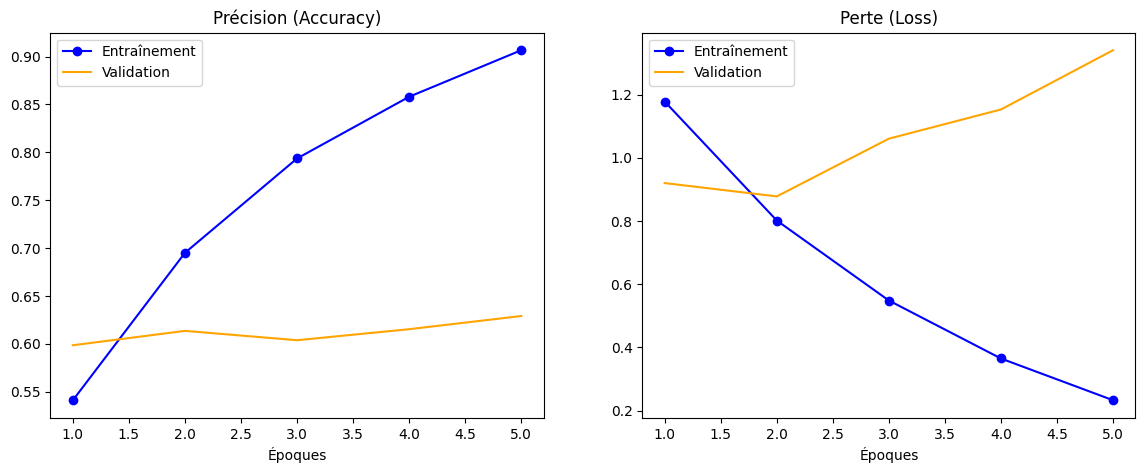

In [12]:
import matplotlib.pyplot as plt

def plot_learning_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Précision
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Entraînement')
    plt.plot(epochs, val_acc, 'orange', label='Validation')
    plt.title('Précision (Accuracy)')
    plt.xlabel('Époques')
    plt.legend()

    # Perte (Loss)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Entraînement')
    plt.plot(epochs, val_loss, 'orange', label='Validation')
    plt.title('Perte (Loss)')
    plt.xlabel('Époques')
    plt.legend()

    plt.show()

plot_learning_curves(history)


--- Evaluation Finale MLP étoiles ---


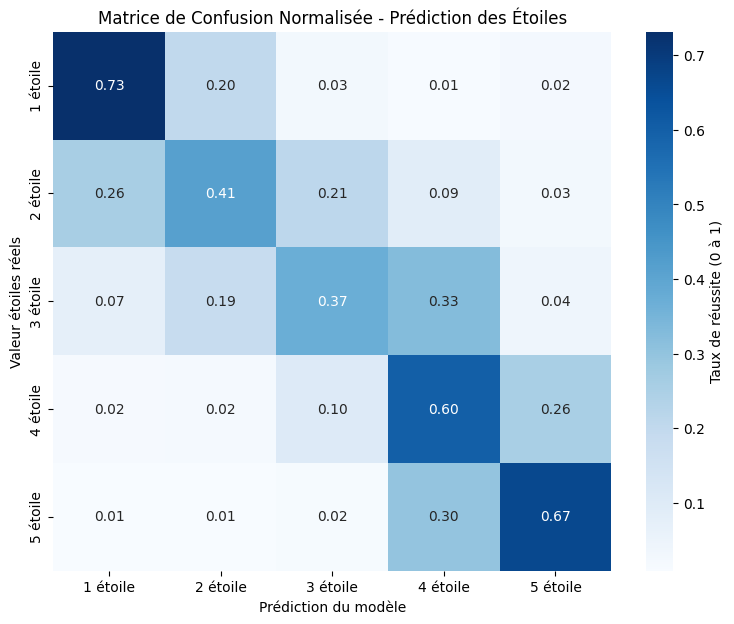

Précision (Accuracy) : 0.6136
F1-Score (ajusté selon la quantité d'avis par étoile)   : 0.6366
Perte (Log Loss)     : 0.8132

Rapport détaillé :
              precision    recall  f1-score   support

    1 étoile       0.75      0.73      0.74       607
    2 étoile       0.37      0.41      0.39       324
    3 étoile       0.41      0.37      0.39       375
    4 étoile       0.42      0.60      0.49       843
    5 étoile       0.83      0.67      0.74      1849

    accuracy                           0.61      3998
   macro avg       0.55      0.56      0.55      3998
weighted avg       0.65      0.61      0.63      3998



In [13]:
import seaborn as sns
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

print("\n--- Evaluation Finale MLP étoiles ---")

y_pred_probs = model_mlp.predict(X_test_tfidf, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Création de la matrice
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

class_names = [f"{star} étoile" for star in le.classes_]

# Affichage avec Seaborn
plt.figure(figsize=(9, 7))
sns.heatmap(cm_norm, 
            annot=True, 
            fmt='.2f', 
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar_kws={'label': 'Taux de réussite (0 à 1)'})

plt.title('Matrice de Confusion Normalisée - Prédiction des Étoiles')
plt.xlabel('Prédiction du modèle')
plt.ylabel('Valeur étoiles réels')
plt.show()

print(f"Précision (Accuracy) : {accuracy_score(y_test, y_pred):.4f}")
print(f"F1-Score (ajusté selon la quantité d'avis par étoile)   : {f1_tfidf :.4f}")
print(f"Perte (Log Loss)     : {loss_tfidf:.4f}")

print("\nRapport détaillé :")
print(classification_report(y_test, y_pred, target_names=class_names))

## 8. Sauvegarder modèle, TF-IDF et LabelEncoder pour les tests 

In [14]:
import pickle

# Sauvegarde du modèle Keras
model_mlp.save('model_etoiles.keras')

# Sauvegarde du TF-IDF et du LabelEncoder
with open('tfidf_etoiles.pkl', 'wb') as f:
    pickle.dump(tfidf, f)
    
with open('label_encoder_etoiles.pkl', 'wb') as f:
    pickle.dump(le, f)

print("Sauvegardes du modèle d'étoiles terminées.")

Sauvegardes du modèle d'étoiles terminées.
